In [1]:
import logging
import os
import pickle

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

import keras
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, LSTM
from keras.layers import ConvLSTM2D, GRU, BatchNormalization, LocallyConnected2D, Permute
from keras.layers import Concatenate, Reshape, Softmax, Conv2DTranspose, Embedding, Multiply
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras import regularizers
from keras import backend as K
import keras.losses

import isolearn.keras

import genesis
import genesis.visualization
import genesis.generator
import genesis.predictor
import genesis.optimizer

import definitions
import definitions.generator
import definitions.generator.optimus5p_25bp_deconv_conv_generator
import definitions.predictor
import definitions.predictor.optimus5p_25bp

Using TensorFlow backend.


In [2]:
%matplotlib inline
matplotlib.rcParams['figure.dpi'] = 120

In [3]:
logging.getLogger('tensorflow').setLevel(logging.ERROR)

# Helper classes and functions

In [4]:
from keras.backend.tensorflow_backend import set_session

def contain_tf_gpu_mem_usage() :
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    set_session(sess)

contain_tf_gpu_mem_usage()

In [5]:
class IdentityEncoder(isolearn.keras.SequenceEncoder) :
    
    def __init__(self, seq_len, channel_map) :
        super(IdentityEncoder, self).__init__('identity', (seq_len, len(channel_map)))
        
        self.seq_len = seq_len
        self.n_channels = len(channel_map)
        self.encode_map = channel_map
        self.decode_map = {
            nt: ix for ix, nt in self.encode_map.items()
        }
    
    def encode(self, seq) :
        encoding = np.zeros((self.seq_len, self.n_channels))
        
        for i in range(len(seq)) :
            if seq[i] in self.encode_map :
                channel_ix = self.encode_map[seq[i]]
                encoding[i, channel_ix] = 1.

        return encoding
    
    def encode_inplace(self, seq, encoding) :
        for i in range(len(seq)) :
            if seq[i] in self.encode_map :
                channel_ix = self.encode_map[seq[i]]
                encoding[i, channel_ix] = 1.
    
    def encode_inplace_sparse(self, seq, encoding_mat, row_index) :
        raise NotImplementError()
    
    def decode(self, encoding) :
        seq = ''
    
        for pos in range(0, encoding.shape[0]) :
            argmax_nt = np.argmax(encoding[pos, :])
            max_nt = np.max(encoding[pos, :])
            seq += self.decode_map[argmax_nt]

        return seq
    
    def decode_sparse(self, encoding_mat, row_index) :
        raise NotImplementError()

In [6]:
class EpochVariableCallback(Callback):
    def __init__(self, my_variable, my_func):
        self.my_variable = my_variable       
        self.my_func = my_func
    def on_epoch_end(self, epoch, logs={}):
        K.set_value(self.my_variable, self.my_func(K.get_value(self.my_variable), epoch))

In [7]:
class GenesisMonitor(Callback):
    def __init__(
            self,
            generator_model,
            sequence_encoder,
            run_dir="",
            run_prefix="",
            n_sequences=32,
            batch_size=32,
            input_tensor_funcs=None):
        self.generator_model = generator_model
        self.batch_size = batch_size
        self.n_sequences = n_sequences
        self.input_tensor_funcs = input_tensor_funcs
        self.sequence_encoder = sequence_encoder
        self.run_prefix = run_prefix
        self.run_dir = run_dir
        
        if not os.path.exists(self.run_dir):
            os.makedirs(self.run_dir)

        seqs = self._sample_sequences()
        self._store_sequences(seqs, 0)
    
    def _sample_sequences(self) :
        n_batches = self.n_sequences // self.batch_size
        
        self.input_tensors = [f() for f in self.input_tensor_funcs]
        
        generator_output = self.generator_model.predict(
            x=self.input_tensors,
            batch_size=self.batch_size)
        _, _, _, _, _, sampled_pwm, _, _, _ = generator_output
        
        seqs = [
            self.sequence_encoder.decode(sampled_pwm[i, 0, :, :, 0])
            for i in range(sampled_pwm.shape[0])
        ]
        
        return seqs
    
    def _store_sequences(self, seqs, epoch) :
        # Save sequences to file
        if self.run_prefix:
            separator = "_"
        else:
            separator = ""
        store_filename = os.path.join(
            self.run_dir,
            self.run_prefix + separator + \
                "epoch_" + str(epoch) + \
                "_" + str(self.n_sequences) + "_sequences.txt")
        with open(store_filename, "wt") as f:
            for i in range(len(seqs)) :
                f.write(seqs[i] + "\n")
    
    def on_epoch_end(self, epoch, logs={}) :
        seqs = self._sample_sequences()
        self._store_sequences(seqs, epoch)

# Train generator model

In [8]:
# Target MRL loss function
def get_mrl_loss(
        target_mrl,
        fitness_weight=2.0,
        fitness_loss_mode='margin',
        entropy_target_bits=1.8,
        entropy_weight=0.0,
        entropy_loss_mode='margin',
        similarity_weight=0.0,
        similarity_margin=0.5):
    
    # Entropy loss function
    if entropy_loss_mode == 'margin' :
        entropy_loss_func = genesis.optimizer.get_margin_entropy_ame(
            pwm_start=0,
            pwm_end=50,
            min_bits=entropy_target_bits)
    elif entropy_loss_mode == 'square':
        entropy_loss_func = genesis.optimizer.get_target_entropy_sme(
            pwm_start=0,
            pwm_end=50,
            target_bits=entropy_target_bits)
    
    # Similarity loss function
    similarity_loss_func = genesis.optimizer.get_pwm_margin_sample_entropy(
        pwm_start=0,
        pwm_end=50,
        margin=similarity_margin,
        shift_1_nt=True)

    def loss_func(loss_tensors) :
        # Unpack inputs
        _, _, _, sequence_class, \
        pwm_logits_1, pwm_logits_2, pwm_1, pwm_2, \
        sampled_pwm_1, sampled_pwm_2, mask, sampled_mask, \
        mrl_pred = loss_tensors
        
        # Fitness loss
        if fitness_loss_mode=='margin':
            mrl_loss = fitness_weight * K.mean(
                K.maximum(
                    -K.print_tensor(
                        mrl_pred[..., 0],
                        message="mrl_pred=") + \
                    target_mrl,
                    K.zeros_like(mrl_pred[..., 0])), axis=1)
        elif fitness_loss_mode=='square':
            mrl_loss = fitness_weight * K.mean(
                (mrl_pred - target_mrl)**2, axis=1)
        elif fitness_loss_mode=='earthmover':
            mrl_loss = -fitness_weight * K.mean(mrl_pred, axis=1)

        # Sequence-specific loss
        seq_loss = 0.0
        
        # Entropy loss
        entropy_loss = entropy_weight * entropy_loss_func(pwm_1)
        
        # Similarity loss
        similarity_loss = similarity_weight * K.mean(
            similarity_loss_func(sampled_pwm_1, sampled_pwm_2), axis=1)
        
        #Compute total loss
        total_loss = mrl_loss + seq_loss + entropy_loss + similarity_loss

        return total_loss
    
    return loss_func

In [9]:
# Function to define and train generator
def run_genesis(
        model_path,
        loss_func,
        sequence_templates,
        run_monitor_dir='',
        batch_size=32,
        n_samples=1,
        n_epochs=10,
        steps_per_epoch=100,
        n_intermediate_sequences=960):
    
    # Build Generator Network
    _, generator = genesis.generator.build_generator(
        batch_size=batch_size,
        seq_length=len(sequence_templates[0]),
        load_generator_function=definitions.generator.optimus5p_25bp_deconv_conv_generator.load_generator_network,
        n_classes=len(sequence_templates),
        n_samples=n_samples,
        sequence_templates=sequence_templates,
        batch_normalize_pwm=False)

    # Build Validation Generator Network
    _, val_generator = genesis.generator.get_generator_copier(generator)(
        batch_size=batch_size,
        seq_length=len(sequence_templates[0]),
        load_generator_function=definitions.generator.optimus5p_25bp_deconv_conv_generator.get_shallow_copy_function(generator),
        n_classes=len(sequence_templates),
        n_samples=n_samples,
        sequence_templates=sequence_templates,
        batch_normalize_pwm=False,
        validation_sample_mode='sample',
        supply_inputs=True)
    
    # Build Predictor Network and hook it on the generator PWM output tensor
    _, predictor = genesis.predictor.build_predictor(
        generator_model=generator,
        load_predictor_function=definitions.predictor.optimus5p_25bp.load_saved_predictor(model_path),
        batch_size=batch_size,
        n_samples=n_samples,
        eval_mode='sample')

    # Build Loss Model (In: Generator seed, Out: Loss function)
    _, loss_model = genesis.optimizer.build_loss_model(
        predictor_model=predictor,
        loss_func=loss_func)
    
    # Specify Optimizer to use
    opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

    # Compile Loss Model (Minimize self)
    loss_model.compile(loss=lambda true, pred: pred, optimizer=opt)
    
    # Randomized validation tensors
    val_random_tensor_funcs = [
        lambda: np.array(np.zeros(n_intermediate_sequences)).reshape(-1, 1),
        lambda: np.random.uniform(-1, 1, (n_intermediate_sequences, 100)),
        lambda: np.random.uniform(-1, 1, (n_intermediate_sequences, 100))
    ]

    # Standard sequence decoder
    acgt_encoder = IdentityEncoder(50, {'A':0, 'C':1, 'G':2, 'T':3})
    
    # Build callback for printing intermediate sequences
    random_genesis_monitor = GenesisMonitor(
        generator_model=val_generator,
        sequence_encoder=acgt_encoder,
        run_dir=run_monitor_dir,
        n_sequences=n_intermediate_sequences,
        batch_size=batch_size,
        input_tensor_funcs=val_random_tensor_funcs)

    # Fit Loss Model
    train_history = loss_model.fit(
        x=[],
        y=np.ones((1, 1)),
        epochs=n_epochs,
        steps_per_epoch=steps_per_epoch,
        callbacks=[random_genesis_monitor]
    )

    return generator, predictor, train_history

In [10]:
# Train generator for optimus 5p
print("Training generator...")

# Directory where to save models
save_dir = 'saved_generators'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

# Number of PWMs to generate per objective
batch_size = 64
# Number of One-hot sequences to sample from the PWM at each grad step
n_samples = 10
# Number of epochs per objective to optimize
n_epochs = 100
# Number of steps (grad updates) per epoch
steps_per_epoch = 100
# Number of sequences to sample and store for each epoch
n_intermediate_sequences = 960

# K.clear_session()

# Pretrained predictor model
saved_predictor_model_dir = 'predictors'
saved_predictor_model_path = os.path.join(
    saved_predictor_model_dir,
    'model_optimus5p_25.h5',
)

# Get MRL loss function
fitness_weight = 0.35
loss_func = get_mrl_loss(
    target_mrl = 8.5,
    fitness_weight=fitness_weight,
    fitness_loss_mode='earthmover',
    entropy_target_bits=1.8,
    entropy_weight=1.0,
    entropy_loss_mode='margin',
    similarity_weight=5.0,
    similarity_margin=0.3,
)

# Model prefix
model_prefix = "genesis_optimus5p_25bp_earthmover_fw_{}".format(int(fitness_weight*100))

# Train generator
generator_model, predictor_model, train_history = run_genesis(
    model_path=saved_predictor_model_path,
    loss_func=loss_func,
    sequence_templates=['N'*25],
    run_monitor_dir='{}/{}_training_data'.format(save_dir, model_prefix),
    batch_size=batch_size,
    n_samples=n_samples,
    n_epochs=n_epochs,
    steps_per_epoch=steps_per_epoch,
    n_intermediate_sequences=n_intermediate_sequences)

# Replace input layers on generator and predictor model
generator_model.get_layer('lambda_rand_sequence_class').function = lambda inp: inp
generator_model.get_layer('lambda_rand_input_1').function = lambda inp: inp
generator_model.get_layer('lambda_rand_input_2').function = lambda inp: inp

predictor_model.get_layer('lambda_rand_sequence_class').function = lambda inp: inp
predictor_model.get_layer('lambda_rand_input_1').function = lambda inp: inp
predictor_model.get_layer('lambda_rand_input_2').function = lambda inp: inp

# Save models
model_name = model_prefix + '_generator.h5'
model_path = os.path.join(save_dir, model_name)
generator_model.save(model_path)
print('Saved trained model at %s ' % model_path)

model_name = model_prefix + '_predictor.h5'
model_path = os.path.join(save_dir, model_name)
predictor_model.save(model_path)
print('Saved trained model at %s ' % model_path)


Training generator...
Epoch 1/100
100/100 [==============================] - 7s 69ms/step - loss: -0.3205
Epoch 2/100
100/100 [==============================] - 4s 41ms/step - loss: -1.6964
Epoch 3/100
100/100 [==============================] - 4s 41ms/step - loss: -1.9065
Epoch 4/100
100/100 [==============================] - 4s 41ms/step - loss: -1.9340
Epoch 5/100
100/100 [==============================] - 4s 42ms/step - loss: -1.9747
Epoch 6/100
100/100 [==============================] - 4s 42ms/step - loss: -1.9811
Epoch 7/100
100/100 [==============================] - 4s 42ms/step - loss: -1.9963
Epoch 8/100
100/100 [==============================] - 4s 42ms/step - loss: -2.0149
Epoch 9/100
100/100 [==============================] - 4s 42ms/step - loss: -2.0372
Epoch 10/100
100/100 [==============================] - 4s 42ms/step - loss: -2.0302
Epoch 11/100
100/100 [==============================] - 4s 42ms/step - loss: -2.0362
Epoch 12/100
100/100 [==============================

100/100 [==============================] - 4s 43ms/step - loss: -2.1214
Epoch 98/100
100/100 [==============================] - 4s 43ms/step - loss: -2.1225
Epoch 99/100
100/100 [==============================] - 4s 43ms/step - loss: -2.1266
Epoch 100/100
100/100 [==============================] - 4s 43ms/step - loss: -2.1183
Saved trained model at saved_generators/genesis_vgg16_25bp_rand_earthmover_fw_35_generator.h5 
Saved trained model at saved_generators/genesis_vgg16_25bp_rand_earthmover_fw_35_predictor.h5 


# Evaluate performance throughout training

In [11]:
# Helper functions
def one_hot_encode(sequences, seq_len=100):
    # Dictionary returning one-hot encoding of nucleotides. 
    nuc_d = {'a':[1,0,0,0],
             'c':[0,1,0,0],
             'g':[0,0,1,0],
             't':[0,0,0,1],
             'n':[0,0,0,0]}
    
    # Creat empty matrix
    vectors = np.empty([len(sequences), seq_len, 4])
    
    # Iterate through sequences and one-hot encode
    for i, seq in enumerate(sequences): 
        seq = seq[:seq_len].lower()
        a = np.array([nuc_d[x] for x in seq])
        vectors[i] = a
    return vectors

In [12]:
# Load pretrained predictor
saved_predictor_model_dir = 'predictors'
saved_predictor = tf.keras.models.load_model(
    os.path.join(
        saved_predictor_model_dir,
        'model_optimus5p_25.h5',
    )
)

In [13]:
data_folder = "saved_generators"
model_prefix = "genesis_optimus5p_25bp_earthmover_fw_{}".format(int(fitness_weight*100))

In [14]:
import editdistance

training_mrl = []
training_distances = []

epoch = 0
while(True):
    epoch_data_filename = '{}/{}_training_data/epoch_{}_960_sequences.txt'.format(
        data_folder,
        model_prefix,
        epoch,
    )
    if os.path.exists(epoch_data_filename):
        
        # Load sequences, one-hot encode
        with open(epoch_data_filename) as f:
            epoch_sequences = f.readlines()
        epoch_sequences = [s.strip() for s in epoch_sequences]
        epoch_sequences_onehot = one_hot_encode(epoch_sequences, seq_len=25)
        
        # Calculate MRL using predictor
        epoch_mrl = saved_predictor.predict(epoch_sequences_onehot).reshape(-1)
        training_mrl.append(epoch_mrl)
        
        # Calculate edit distance
        shuffle_index = np.arange(len(epoch_sequences))
        np.random.shuffle(shuffle_index)

        distances = []
        for i in range(len(epoch_sequences)) :
#             if i == shuffle_index[i]:
#                 continue
            seq_1 = epoch_sequences[i]
            seq_2 = epoch_sequences[shuffle_index[i]]
            dist = editdistance.eval(seq_1, seq_2)
            distances.append(dist)

        distances = np.array(distances) / len(epoch_sequences[0])
        training_distances.append(distances)

    else:
        break
    epoch += 1
    
training_mrl = np.array(training_mrl)
training_distances = np.array(training_distances)

Text(0, 0.5, 'Edit distance')

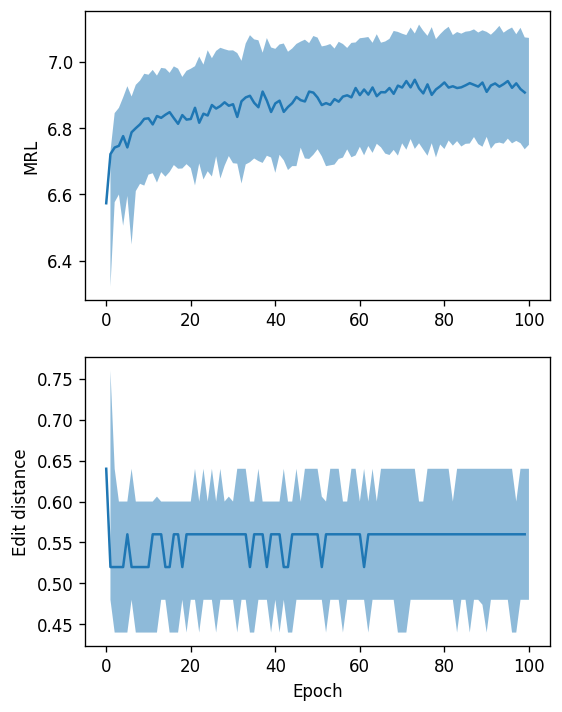

In [15]:
# Plot MRL and edit distance during training
fig = plt.figure(figsize=(5, 7))
ax = fig.add_subplot(2, 1, 1)
ax.plot(np.median(training_mrl, axis=1))
ax.fill_between(
    np.arange(training_mrl.shape[0]) + 1,
    np.percentile(training_mrl, 15, axis=1),
    np.percentile(training_mrl, 85, axis=1),
    alpha=0.5,
)
# ax.set_xlabel('Epoch')
ax.set_ylabel('MRL')

ax = fig.add_subplot(2, 1, 2)
ax.plot(np.median(training_distances, axis=1))
ax.fill_between(
    np.arange(training_distances.shape[0]) + 1,
    np.percentile(training_distances, 15, axis=1),
    np.percentile(training_distances, 85, axis=1),
    alpha=0.5,
)
ax.set_xlabel('Epoch')
ax.set_ylabel('Edit distance')

# Evaluate trained generator

In [6]:
import logomaker

def plot_pwm(pwm, title=None):
    # Calculate entropy and conservation
    entropy = np.zeros_like(pwm)
    entropy[pwm > 0] = pwm[pwm > 0] * -np.log2(pwm[pwm > 0])
    entropy = np.sum(entropy, axis=1)
    conservation = 2 - entropy
    # Nucleotide height
    nt_height = np.tile(np.reshape(conservation, (-1, 1)), (1, 4))
    nt_height = pwm * nt_height

    nt_height_df = pd.DataFrame(
        nt_height,
        columns=['A', 'C', 'G', 'T'],
    )

    fig = plt.figure(figsize=(6, 0.4))
    ax = fig.add_subplot(1, 1, 1)
    logo = logomaker.Logo(
        nt_height_df,
        color_scheme='classic',
        ax=ax,
    )
    logo.style_spines(visible=False)
    logo.style_spines(spines=['bottom'], visible=True, linewidth=2)
    ax.set_xticks([])
    ax.set_yticks([])
    if title is not None:
        ax.set_title(title)

In [8]:
# Load trained generator
# fitness_weight = 0.35
save_dir = 'saved_generators'
generator_model_prefix = "genesis_optimus5p_25bp_earthmover_fw_{}".format(int(fitness_weight*100))
generator_model_path = os.path.join(
    save_dir,
    generator_model_prefix + '_generator.h5',
)
generator = load_model(
    generator_model_path,
    custom_objects={
        'st_sampled_softmax': genesis.generator.st_sampled_softmax,
        'st_hardmax_softmax': genesis.generator.st_hardmax_softmax,
    }
)

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [9]:
# Load pretrained predictor
saved_predictor_model_dir = 'predictor'
saved_predictor = tf.keras.models.load_model(
    os.path.join(
        saved_predictor_model_dir,
        'model_optimus5p_25.h5',
    )
)

In [30]:
# Generate sequences and plot MRLs
batch_size = 64
n = 1000
n = int(n / batch_size) * batch_size + batch_size

sequence_class = np.array([0] * n).reshape(-1, 1) 
noise_1 = np.random.uniform(-1, 1, (n, 100))
noise_2 = np.random.uniform(-1, 1, (n, 100))

# Generate sequences
pred_outputs = generator.predict([sequence_class, noise_1, noise_2], batch_size=batch_size)
_, _, _, optimized_pwm, _, sampled_pwm, _, _, _ = pred_outputs
generated_pwm = optimized_pwm[:, :, :, 0]
generated_onehot = sampled_pwm[:, 0, :, :, 0]

# Predict MRL using model
mrl_pred = saved_predictor.predict(generated_onehot).reshape(-1)

print("Mean MRL = {}".format(np.mean(mrl_pred)))
print("Std MRL = {}".format(np.std(mrl_pred)))

Mean MRL = 6.924163818359375
Std MRL = 0.16012071073055267


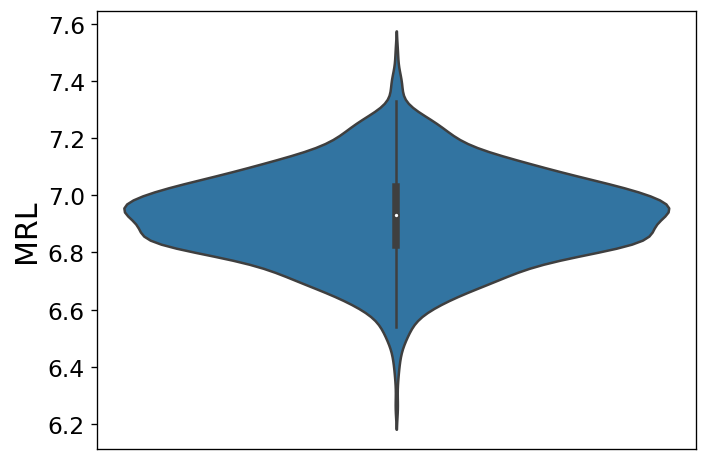

In [31]:
# Plot MRL violin
f = plt.figure(figsize=(6, 4))

sns.violinplot(data=[mrl_pred])
plt.xticks([], [])
plt.yticks(fontsize=14)
plt.ylabel('MRL', fontsize=18)
plt.tight_layout()

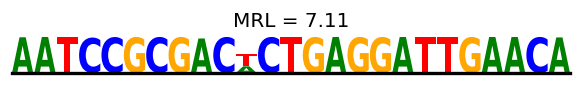

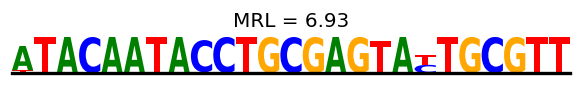

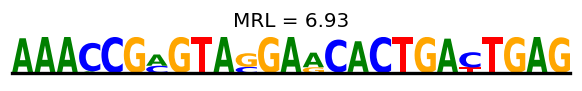

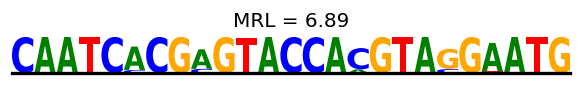

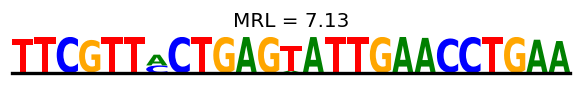

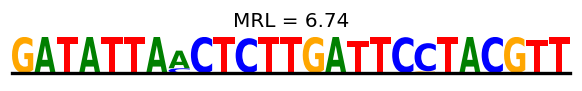

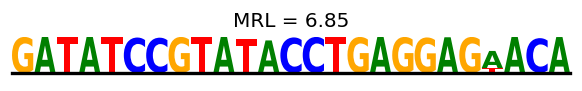

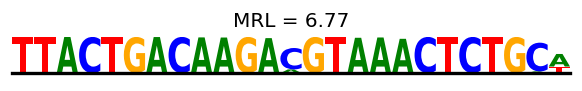

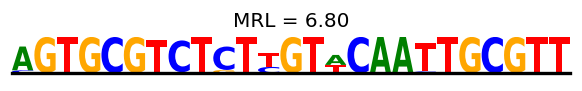

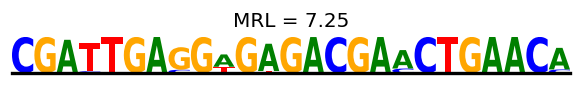

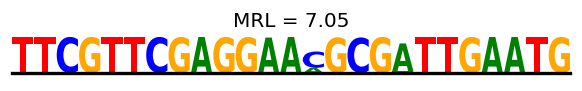

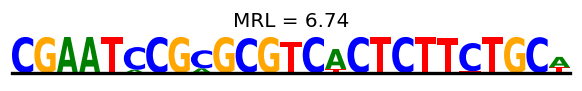

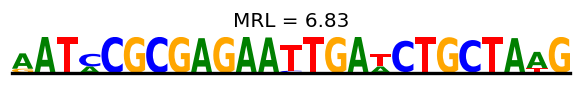

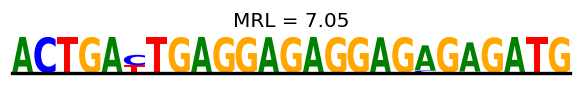

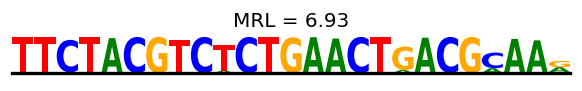

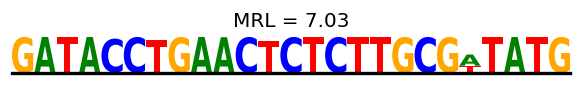

In [21]:
# Plot random sequences from generated set
sampled_pwm_indices = np.random.choice(
    np.arange(generated_pwm.shape[0]),
    size=16,
    replace=False)

for pwm_index in sampled_pwm_indices:
    plot_pwm(
        generated_pwm[pwm_index, :, :],
        title='MRL = {:.2f}'.format(mrl_pred[pwm_index]))

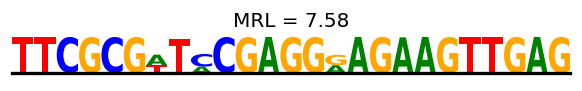

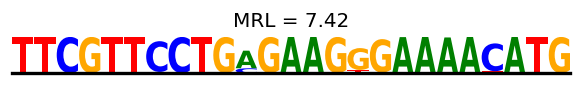

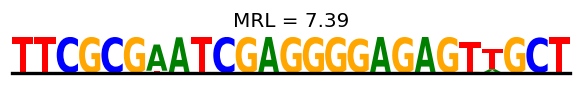

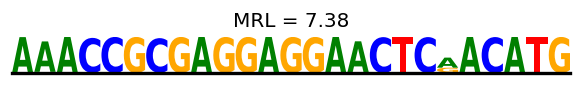

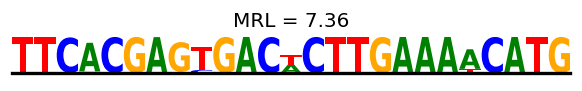

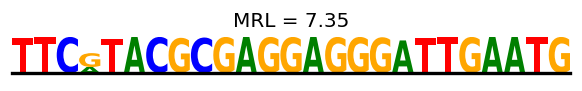

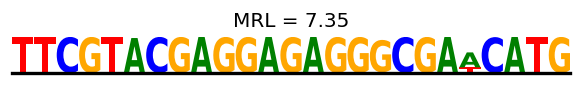

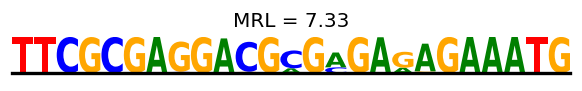

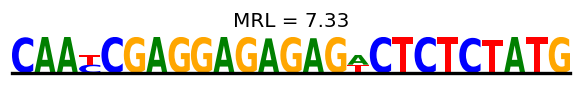

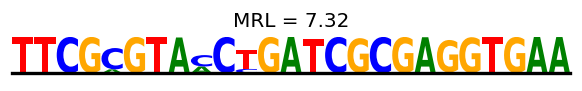

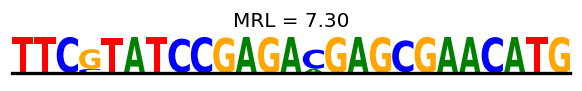

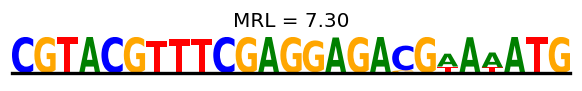

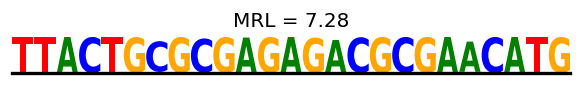

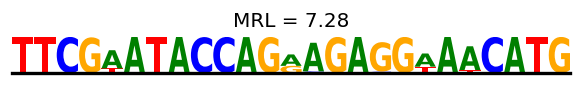

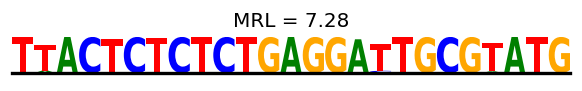

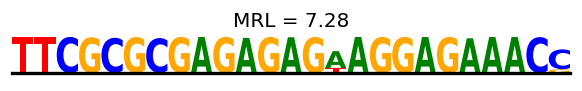

In [22]:
# Plot sequences with highest MRL in generated set
max_pwm_indices = np.argsort(mrl_pred)[::-1]
max_pwm_indices = max_pwm_indices[:16]

for pwm_index in max_pwm_indices:
    plot_pwm(
        generated_pwm[pwm_index, :, :],
        title='MRL = {:.2f}'.format(mrl_pred[pwm_index]))

In [23]:
# Standard sequence decoder
acgt_encoder = IdentityEncoder(50, {'A':0, 'C':1, 'G':2, 'T':3})

# Calculate average/std nucleotide entropy
nt_entropies = []
for j in range(generated_onehot.shape[1]):
    p_A = np.sum(generated_onehot[:, j, 0]) / n
    p_C = np.sum(generated_onehot[:, j, 1]) / n
    p_G = np.sum(generated_onehot[:, j, 2]) / n
    p_T = np.sum(generated_onehot[:, j, 3]) / n

    nt_entropy = 0
    if (p_A * p_C * p_G * p_T) > 0. :
        nt_entropy = - (p_A * np.log2(p_A) + \
                        p_C * np.log2(p_C) + \
                        p_G * np.log2(p_G) + \
                        p_T * np.log2(p_T))

    nt_entropies.append(nt_entropy)
nt_entropies = np.array(nt_entropies)

print("Mean NT Entropy = " + str(round(np.mean(nt_entropies), 4)))
print("Std NT Entropy = " + str(round(np.std(nt_entropies), 4)))

# Calculate hexamer entropies
hexamer_encoder = isolearn.keras.NMerEncoder(n_mer_len=6, count_n_mers=True)
hexamers = isolearn.keras.SparseBatchEncoder(encoder=hexamer_encoder)([
    acgt_encoder.decode(generated_onehot[i, :, :])
    for i in range(generated_onehot.shape[0])
])
hexamer_sum = np.ravel(hexamers.sum(axis=0))
hexamers_probs = hexamer_sum / np.sum(hexamer_sum)
n_nonzero_hexamers = len(np.nonzero(hexamer_sum > 0)[0])
hexamer_entropy = - np.sum(hexamers_probs[hexamer_sum > 0] * \
                           np.log2(hexamers_probs[hexamer_sum > 0]))

print("Number of unique hexamers = " + str(n_nonzero_hexamers))
print("Hexamer Entropy = " + str(hexamer_entropy))

# Calculate average/std hexamer entropy
nonzero_index = np.nonzero(hexamer_sum > 0)[0]
hexamer_entropies = []
for j in range(n_nonzero_hexamers) :
    p_on = len(np.nonzero(hexamers[:, nonzero_index[j]] > 0)[0]) / hexamers.shape[0]
    p_off = 1. - p_on
    hexamer_entropy = 0
    if p_on * p_off > 0.:
        hexamer_entropy = -(p_on * np.log2(p_on) + p_off * np.log2(p_off))
    hexamer_entropies.append(hexamer_entropy)

hexamer_entropies = np.array(hexamer_entropies)

print("Mean Binary Hexamer Entropy = " + str(round(np.mean(hexamer_entropies), 4)))
print("Std Binary Hexamer Entropy = " + str(round(np.std(hexamer_entropies), 4)))

Mean NT Entropy = 1.7418
Std NT Entropy = 0.5265
Number of unique hexamers = 2284
Hexamer Entropy = 10.05165187583705
Mean Binary Hexamer Entropy = 0.0621
Std Binary Hexamer Entropy = 0.0748


mean distance/nt = 0.5563
std distance/nt = 0.0807


Text(0, 0.5, 'Edit distance / nucleotide')

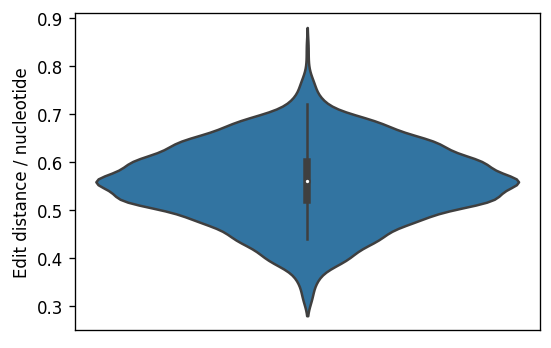

In [24]:
import editdistance

# Calculate random pair-wise edit distances
generated_sequences = [
    acgt_encoder.decode(generated_onehot[i, :, :])
    for i in range(generated_onehot.shape[0])
]

shuffle_index = np.arange(len(generated_sequences))
np.random.shuffle(shuffle_index)

distances = []
for i in range(len(generated_sequences)) :
    if i == shuffle_index[i] :
        continue
    seq_1 = generated_sequences[i]
    seq_2 = generated_sequences[shuffle_index[i]]
    dist = editdistance.eval(seq_1, seq_2)
    distances.append(dist)

distances = np.array(distances) / len(generated_sequences[0])

print("mean distance/nt = " + str(round(np.mean(distances), 4)))
print("std distance/nt = " + str(round(np.std(distances), 4)))

# Plot violin of edit distances
f = plt.figure(figsize=(5, 3.5))
sns.violinplot(data=[distances])
plt.xticks([], [])
plt.ylabel('Edit distance / nucleotide')

([], [])

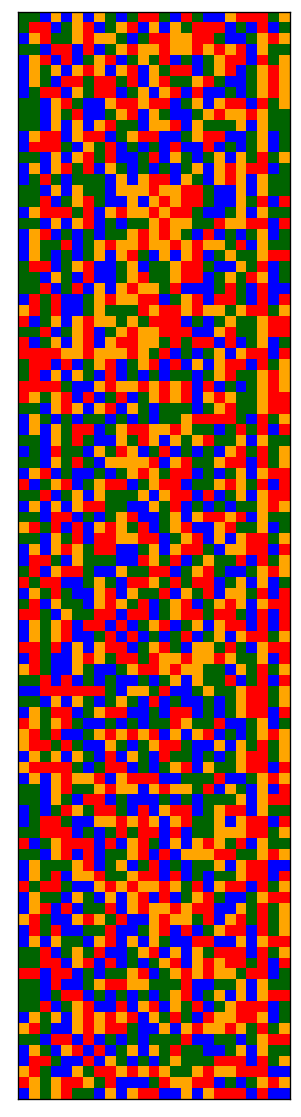

In [25]:
# Plot generated sequences as colormaps
plot_n_seqs = 100

flat_pwms = np.zeros((generated_pwm.shape[0], generated_pwm.shape[1]))
for i in range(generated_pwm.shape[0]) :
    for j in range(generated_pwm.shape[1]) :
        max_nt_ix = np.argmax(generated_pwm[i, j, :])
        flat_pwms[i, j] = max_nt_ix + 1
flat_pwms = flat_pwms[:plot_n_seqs, :]

# Plot
cmap = matplotlib.colors.ListedColormap(['red', 'blue', 'orange', 'darkgreen'])
bounds=[0, 1, 2, 3, 4, 5]
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

f = plt.figure(figsize=(4, 12))

plt.imshow(flat_pwms, aspect='equal', interpolation='nearest', origin='lower', cmap=cmap, norm=norm)
plt.xticks([], [])
plt.yticks([], [])

# Export designed sequences

In [28]:
generator_model_prefix
generated_table = pd.DataFrame(
    {
        'utr': generated_sequences,
        'rl': mrl_pred.reshape(-1),
    }
)
generated_table = generated_table.sort_values('rl', ascending=False)
generated_table.to_csv('{}_sequences.csv'.format(generator_model_prefix), index=False)
generated_table

,utr,rl
795,TTCGCGATCCGAGGGAGAAGTTGAG,7.584120
766,TTCGTTCCTGAGAAGGGAAAACATG,7.415158
524,TTCGCGAATCGAGGGGAGAGTTGCT,7.392587
912,AAACCGCGAGGAGGAACTCAACATG,7.377105
807,TTCACGAGTGACTCTTGAAAACATG,7.364337
...,...,...
44,AATCGTTAACAACTGAATAATCACA,6.463675
959,ACTGCGGGACGTTTGAGAAGTTAAG,6.460850
925,CGTGAGAGTATAAACTGAGGCTAGG,6.455497
1002,AAAAATAACACTGCGCGTAAACACA,6.408117
